# Train - LSTM


리더보드 ACC: 0.3821

reference: https://arxiv.org/pdf/2311.06280

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# import lightgbm as lgb
# from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
from boruta import BorutaPy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings(action='ignore')



def random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    
    return True
random_seed(seed=42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


## Data

In [2]:
''' 
train_df = train_label + train_data
test_df = test_label + test_data

all_df = all_label + all_data
'''

dir_path = "/data/ephemeral/home/data"

data_path = "./data.csv"
all_df = pd.read_csv(data_path)

train_df = all_df.loc[all_df["_type"]=="train"].drop(columns=["_type"])
test_df = all_df.loc[all_df["_type"]=="test"].drop(columns=["_type"])
print("data shape: ", all_df.shape)
print("train shape: ", train_df.shape)
print("test shape: ", test_df.shape)

data shape:  (11552, 509)
train shape:  (8760, 508)
test shape:  (2792, 508)


## Feature Selection

In [3]:
# 특성 선택 함수
def select_features(X, y, n_features=50):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    return feature_importance.head(n_features)['feature'].tolist()

In [4]:
# x = train_df.drop(columns=['ID', 'target'])
# y = train_df['target']
# print("X: ", x.shape)
# print("Y: ", y.shape)

# # selected_features = select_features(x, y)
# selected_features = ['open_interest_rolling_std_2', 'receiver_count_shift_10', 'sender_count_shift_10', 'funding_rates_rolling_std_2', 'sender_count_rolling_std_2', 
#                    'funding_rates_rolling_std_3', 'receiver_count_rolling_std_2', 'funding_rates_shift_10', 'volume_diff_rolling_std_2', 'open_interest_rolling_std_3']
# # selected_features = x.columns.tolist()
# print(len(selected_features))

# x = train_df.drop(columns=['ID', 'target'])[selected_features]
# y = train_df['target']
# print("X: ", x.shape)
# print("Y: ", y.shape)


In [5]:
x = train_df.drop(columns=['ID', 'target'])
y = train_df['target']
print("X: ", x.shape)
print("Y: ", y.shape)


# Random Forest 분류기 초기화
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Boruta 특성 선택기 초기화
boruta_selector = BorutaPy(
    rf, 
    n_estimators='auto', 
    verbose=1, 
    random_state=42
)

# Boruta 실행
boruta_selector.fit(x.values, y)

# 선택된 특성 확인
selected_features = x.columns[boruta_selector.support_].tolist()
print("선택된 특성:", selected_features)

# 선택된 특성의 순위 확인
feature_ranks = list(zip(x.columns, boruta_selector.ranking_))
print("특성 순위:", feature_ranks)

# 선택된 특성만 포함하는 새로운 데이터셋 생성
X_selected = boruta_selector.transform(x.values)
print("원본 특성 수:", x.shape[1])
print("선택된 특성 수:", X_selected.shape[1])


x = train_df.drop(columns=['ID', 'target'])[selected_features]
y = train_df['target']
print("X: ", x.shape)
print("Y: ", y.shape)


X:  (8760, 506)
Y:  (8760,)
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
I

In [6]:
class CoinDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.LongTensor(y.values)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        xx = self.x[idx]
        yy = self.y[idx]

        return xx, yy


In [7]:

x = train_df.drop(columns=['ID', 'target'])[selected_features]
y = train_df['target']
print("X: ", x.shape)
print("Y: ", y.shape)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)
print("Train: ", x_train.shape, y_train.shape)
print("Val: ", x_val.shape, y_val.shape)

scale = RobustScaler()
x_train = scale.fit_transform(x_train)
x_val = scale.transform(x_val)

train_dataset = CoinDataset(x_train, y_train)
val_dataset = CoinDataset(x_val, y_val)

print("train: ", len(train_dataset))
print(y_train.value_counts())

print("val: ", len(val_dataset))
print(y_val.value_counts())

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


X:  (8760, 52)
Y:  (8760,)
Train:  (7008, 52) (7008,)
Val:  (1752, 52) (1752,)
train:  7008
target
2.0    2937
1.0    2835
3.0     644
0.0     592
Name: count, dtype: int64
val:  1752
target
2.0    734
1.0    709
3.0    161
0.0    148
Name: count, dtype: int64


In [8]:
# Bi-LSTM 모델 정의
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.relu(out)
        out = self.dropout1(out)

        out, _ = self.lstm2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.fc(out)
        
        return out


In [9]:
epochs = 50
learning_rate = 1e-5


input_size = len(selected_features)
hidden_size = 64
num_layers = 2
dropout = 0.2

model = BiLSTMModel(input_size, hidden_size, num_layers, dropout)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train

In [10]:
print("Start Train...")
min_loss = float('inf')
train_loss_hist = []
val_loss_hist = []
for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        train_loss += loss
        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(train_dataloader)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss

        val_loss = val_loss / len(val_dataloader)

    # Save model
    if val_loss < min_loss:
        print("Model Save")
        min_loss = val_loss
        torch.save(model, f"./models/lstm.pt")

    val_loss_hist.append(val_loss.cpu().detach().numpy())
    train_loss_hist.append(train_loss.cpu().detach().numpy())
    print(f"Epoch: {epoch+1}/{epochs}, train loss: {train_loss}, val loss: {val_loss}")



Start Train...


  2%|▏         | 1/50 [00:44<36:23, 44.55s/it]

Model Save
Epoch: 1/50, train loss: 1.322967767715454, val loss: 1.2556993961334229


  4%|▍         | 2/50 [01:29<35:53, 44.86s/it]

Model Save
Epoch: 2/50, train loss: 1.1804289817810059, val loss: 1.146176815032959


  6%|▌         | 3/50 [02:14<35:13, 44.97s/it]

Model Save
Epoch: 3/50, train loss: 1.1393526792526245, val loss: 1.1382489204406738


  8%|▊         | 4/50 [02:59<34:28, 44.97s/it]

Model Save
Epoch: 4/50, train loss: 1.1326628923416138, val loss: 1.1361212730407715


 10%|█         | 5/50 [03:44<33:37, 44.84s/it]

Model Save
Epoch: 5/50, train loss: 1.1302329301834106, val loss: 1.1351674795150757


 12%|█▏        | 6/50 [04:28<32:49, 44.75s/it]

Model Save
Epoch: 6/50, train loss: 1.1280744075775146, val loss: 1.1344212293624878


 14%|█▍        | 7/50 [05:13<32:05, 44.79s/it]

Model Save
Epoch: 7/50, train loss: 1.1283528804779053, val loss: 1.1340047121047974


 16%|█▌        | 8/50 [05:58<31:21, 44.79s/it]

Model Save
Epoch: 8/50, train loss: 1.1252734661102295, val loss: 1.1336872577667236


 18%|█▊        | 9/50 [06:43<30:32, 44.70s/it]

Model Save
Epoch: 9/50, train loss: 1.125553011894226, val loss: 1.1334030628204346


 20%|██        | 10/50 [07:27<29:50, 44.75s/it]

Model Save
Epoch: 10/50, train loss: 1.1254976987838745, val loss: 1.1332895755767822


 22%|██▏       | 11/50 [08:12<29:04, 44.72s/it]

Model Save
Epoch: 11/50, train loss: 1.1245230436325073, val loss: 1.1331367492675781


 24%|██▍       | 12/50 [08:57<28:17, 44.68s/it]

Model Save
Epoch: 12/50, train loss: 1.1235311031341553, val loss: 1.1329095363616943


 26%|██▌       | 13/50 [09:41<27:31, 44.64s/it]

Model Save
Epoch: 13/50, train loss: 1.1232059001922607, val loss: 1.132794976234436


 28%|██▊       | 14/50 [10:26<26:45, 44.60s/it]

Epoch: 14/50, train loss: 1.1226261854171753, val loss: 1.1328555345535278


 30%|███       | 15/50 [11:10<26:01, 44.63s/it]

Model Save
Epoch: 15/50, train loss: 1.1225107908248901, val loss: 1.1325727701187134


 32%|███▏      | 16/50 [11:55<25:17, 44.63s/it]

Epoch: 16/50, train loss: 1.1236008405685425, val loss: 1.1328606605529785


 34%|███▍      | 17/50 [12:40<24:31, 44.59s/it]

Epoch: 17/50, train loss: 1.1220824718475342, val loss: 1.1327083110809326


 36%|███▌      | 18/50 [13:25<23:51, 44.72s/it]

Epoch: 18/50, train loss: 1.121764063835144, val loss: 1.1326019763946533


 38%|███▊      | 19/50 [14:10<23:09, 44.82s/it]

Model Save
Epoch: 19/50, train loss: 1.1210089921951294, val loss: 1.1323773860931396


 40%|████      | 20/50 [14:55<22:26, 44.87s/it]

Model Save
Epoch: 20/50, train loss: 1.122257947921753, val loss: 1.1321460008621216


 42%|████▏     | 21/50 [15:39<21:41, 44.88s/it]

Epoch: 21/50, train loss: 1.121502161026001, val loss: 1.1321625709533691


 44%|████▍     | 22/50 [16:24<20:52, 44.73s/it]

Epoch: 22/50, train loss: 1.1223030090332031, val loss: 1.1323256492614746


 46%|████▌     | 23/50 [17:08<20:06, 44.70s/it]

Model Save
Epoch: 23/50, train loss: 1.1206495761871338, val loss: 1.1318751573562622


 48%|████▊     | 24/50 [17:53<19:20, 44.63s/it]

Epoch: 24/50, train loss: 1.120209813117981, val loss: 1.1321903467178345


 50%|█████     | 25/50 [18:37<18:33, 44.53s/it]

Model Save
Epoch: 25/50, train loss: 1.1204231977462769, val loss: 1.131772756576538


 52%|█████▏    | 26/50 [19:22<17:47, 44.47s/it]

Model Save
Epoch: 26/50, train loss: 1.1210163831710815, val loss: 1.1316744089126587


 54%|█████▍    | 27/50 [20:06<17:02, 44.44s/it]

Epoch: 27/50, train loss: 1.1194446086883545, val loss: 1.1319371461868286


 56%|█████▌    | 28/50 [20:50<16:17, 44.43s/it]

Model Save
Epoch: 28/50, train loss: 1.1206636428833008, val loss: 1.131534457206726


 58%|█████▊    | 29/50 [21:35<15:33, 44.44s/it]

Epoch: 29/50, train loss: 1.1198769807815552, val loss: 1.1316558122634888


 60%|██████    | 30/50 [22:19<14:49, 44.48s/it]

Epoch: 30/50, train loss: 1.1184260845184326, val loss: 1.131569743156433


 62%|██████▏   | 31/50 [23:04<14:06, 44.55s/it]

Model Save
Epoch: 31/50, train loss: 1.119046926498413, val loss: 1.1314220428466797


 64%|██████▍   | 32/50 [23:49<13:22, 44.56s/it]

Model Save
Epoch: 32/50, train loss: 1.1178689002990723, val loss: 1.1312483549118042


 66%|██████▌   | 33/50 [24:33<12:37, 44.53s/it]

Epoch: 33/50, train loss: 1.1198738813400269, val loss: 1.1313652992248535


 68%|██████▊   | 34/50 [25:18<11:52, 44.54s/it]

Epoch: 34/50, train loss: 1.1179311275482178, val loss: 1.1315361261367798


 70%|███████   | 35/50 [26:02<11:08, 44.58s/it]

Epoch: 35/50, train loss: 1.117958664894104, val loss: 1.1316111087799072


 72%|███████▏  | 36/50 [26:47<10:23, 44.54s/it]

Epoch: 36/50, train loss: 1.1180862188339233, val loss: 1.131663203239441


 74%|███████▍  | 37/50 [27:31<09:39, 44.56s/it]

Epoch: 37/50, train loss: 1.1177626848220825, val loss: 1.1313823461532593


 76%|███████▌  | 38/50 [28:16<08:55, 44.59s/it]

Epoch: 38/50, train loss: 1.116622805595398, val loss: 1.1319838762283325


 78%|███████▊  | 39/50 [29:01<08:10, 44.60s/it]

Epoch: 39/50, train loss: 1.1166495084762573, val loss: 1.1317996978759766


 80%|████████  | 40/50 [29:45<07:25, 44.51s/it]

Epoch: 40/50, train loss: 1.1158795356750488, val loss: 1.1316890716552734


 82%|████████▏ | 41/50 [30:30<06:41, 44.59s/it]

Epoch: 41/50, train loss: 1.115624189376831, val loss: 1.1317399740219116


 84%|████████▍ | 42/50 [31:14<05:56, 44.60s/it]

Epoch: 42/50, train loss: 1.1168618202209473, val loss: 1.1312756538391113


 86%|████████▌ | 43/50 [31:59<05:11, 44.56s/it]

Epoch: 43/50, train loss: 1.114371418952942, val loss: 1.1318727731704712


 88%|████████▊ | 44/50 [32:43<04:27, 44.57s/it]

Model Save
Epoch: 44/50, train loss: 1.1155407428741455, val loss: 1.1311002969741821


 90%|█████████ | 45/50 [33:28<03:43, 44.66s/it]

Model Save
Epoch: 45/50, train loss: 1.1151396036148071, val loss: 1.1309094429016113


 92%|█████████▏| 46/50 [34:13<02:58, 44.62s/it]

Epoch: 46/50, train loss: 1.1153333187103271, val loss: 1.1311283111572266


 94%|█████████▍| 47/50 [34:58<02:13, 44.62s/it]

Epoch: 47/50, train loss: 1.1132797002792358, val loss: 1.131281852722168


 96%|█████████▌| 48/50 [35:42<01:29, 44.62s/it]

Epoch: 48/50, train loss: 1.1134161949157715, val loss: 1.131558895111084


 98%|█████████▊| 49/50 [36:27<00:44, 44.60s/it]

Epoch: 49/50, train loss: 1.1139333248138428, val loss: 1.1310904026031494


100%|██████████| 50/50 [37:11<00:00, 44.63s/it]

Epoch: 50/50, train loss: 1.112494945526123, val loss: 1.1311733722686768


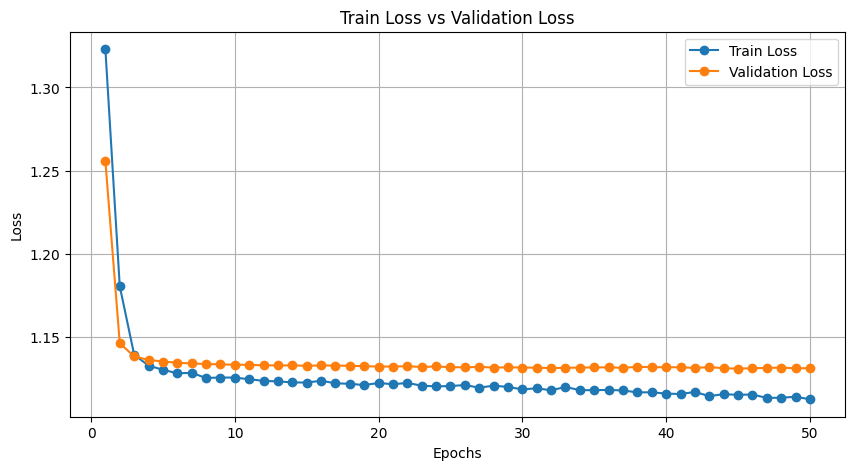

In [11]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_loss_hist, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_loss_hist, label='Validation Loss', marker='o')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

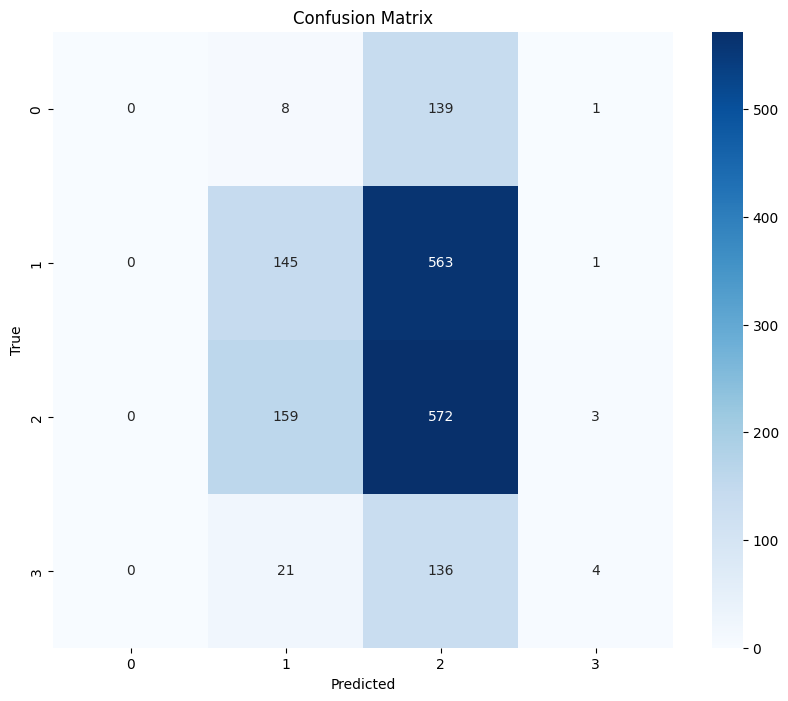

In [12]:
model = torch.load('./models/lstm.pt')
model.eval() 
val_gt_lst = []
val_pred_lst = []
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        pred = model(inputs)
        _, pred_class = torch.max(pred.data, 1)

        val_gt_lst.append(labels.item())
        val_pred_lst.append(pred_class.item())

val_gt_lst = np.array(val_gt_lst)
val_pred_lst = np.array(val_pred_lst)

# Confusion Matrix 계산
cm = confusion_matrix(val_gt_lst, val_pred_lst)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Test

In [13]:
# load mode
model = torch.load('./models/lstm.pt')
model.eval() 

# test data
test_df = all_df.loc[all_df["_type"]=="test"].drop(columns=["_type"])
print("test shape: ", test_df.shape)

test_data = test_df[selected_features].values
test_data = scale.transform(test_data)
print("test data shape: ", test_data.shape)

pred_lst = []
with torch.no_grad():
    for data in tqdm(test_data):
        data = torch.FloatTensor(data.reshape(1, -1)).to(device)

        pred = model(data)
        _, pred_class = torch.max(pred.data, 1)

        pred_lst.append(pred_class.item())

pred_lst = np.array(pred_lst)


test shape:  (2792, 508)
test data shape:  (2792, 52)


100%|██████████| 2792/2792 [00:02<00:00, 1273.39it/s]


In [14]:
pred_lst

array([2, 2, 2, ..., 1, 1, 1])

In [15]:
submission_df = pd.read_csv(f"{dir_path}/test.csv")
submission_df = submission_df.assign(target=pred_lst)
submission_df.to_csv("output.csv", index=False)

print(submission_df.target.value_counts())
submission_df

target
2    2050
1     688
3      54
Name: count, dtype: int64


,ID,target
0,2024-01-01 00:00:00,2
1,2024-01-01 01:00:00,2
2,2024-01-01 02:00:00,2
3,2024-01-01 03:00:00,2
4,2024-01-01 04:00:00,2
...,...,...
2787,2024-04-26 03:00:00,1
2788,2024-04-26 04:00:00,1
2789,2024-04-26 05:00:00,1
2790,2024-04-26 06:00:00,1
